In [ ]:
import os
import cv2
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pycocotools.coco import COCO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as T


In [ ]:
class Model(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(Model, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up3 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256+128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128+64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64+32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return out


if __name__ == "__main__":
    model = Model()
    x = torch.randn(1, 3, 512, 512)
    y = model(x)
    print("Input:", x.shape)
    print("Output:", y.shape)


Input: torch.Size([1, 3, 512, 512])
Output: torch.Size([1, 1, 512, 512])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model()
model.load_state_dict(torch.load("model_state_dict.pth", map_location=device))
model.to(device)
model.eval()

def preprocess_image(image_path, device, input_size=(512, 512)):

    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    h, w = orig_img.shape[:2]

    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(input_size),
        T.ToTensor()
    ])

    img_tensor = transform(orig_img).unsqueeze(0).to(device)
    return img_tensor, orig_img, (h, w)


def predict_mask(model, img_tensor, orig_size, threshold=0.5):

    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output)
        output = output.squeeze().cpu().numpy()

    mask = (output > threshold).astype(np.uint8)

    mask_resized = cv2.resize(mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)
    return mask_resized



def visualize_pipeline(orig_img, mask):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(orig_img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(orig_img)
    plt.imshow(mask, alpha=0.5, cmap="Reds")
    plt.axis("off")

    plt.show()

def run_inference(image_path, model, device, input_size=(512, 512), threshold=0.5):
    img_tensor, orig_img, orig_size = preprocess_image(image_path, device, input_size)
    pred_mask = predict_mask(model, img_tensor, orig_size, threshold)
    visualize_pipeline(orig_img, pred_mask)
    return pred_mask


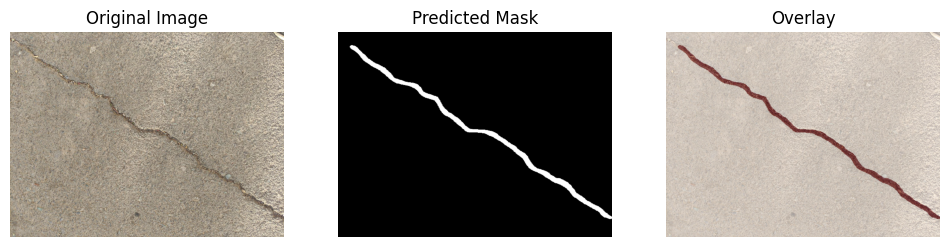

In [ ]:
mask = run_inference("5.jpg", model, device, input_size=(512, 512), threshold=0.5)